In [ ]:
'''
    (a) Random forest for lunar crater image classification
    (b) Version number: 1
    (c) Autors: davribsan
    (d) Date of initializaition: 01/10/24
    (e) Description of the program: 
        This program implements a complete workflow for lunar crater image classification
        using a Random Forest, including model training and performance evaluation.

    (f) Sources:
        - Machine Learning course contents from IST
        - RandomForestClassifier documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        
    g) Range of validity expected of the parameters and range tested:

        - Expected and Tested: 48*48 pixel grayscale images 

    (h) Inputs:

        k_folds: number of folds for cross-validation in RandomizedSearchCV
        combinations: number of hyperparameter combinations randomly sampled and evaluated in RandomizedSearchCV. 
        prob_thresh: minimum predicted probability that a sample must reach to be considered as belonging to a certain class in the extra dataset

    (i) Outputs:

        Accuracy of the model with oversampled and no extra data 
        F1 score of the model with oversampled and no extra data 
        Confusion matrix of the model with oversampled and no extra data 
        Accuracy of the model with oversampled and extra data 
        F1 score of the model with oversampled and extra data 
        Confusion matrix of the model with oversampled and extra data 

    (j) List of dependencies:
            - NumPy: numerical computations and array manipulation
            - Matplotlib: visualization of images and training curves
            - scikit-learn: dataset splitting, F1 score, accuracy and confusion matrix
            - imbalanced-learn (imblearn): Random Over Sampling (ROS) for class balancing
        
    (k) Software version: Python 3.12.4
    '''

# Inputs

The Inputs section establishes all the foundational elements required for the project. It includes importing essential libraries, loading the dataset, and defining key parameters for the classifier. 

## Libraries

This subsection imports all the Python libraries required for the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Classifier Parameters

This section presents the main parameters used to configure the classifier throughout the experiments. These include the number of folds applied during cross-validation, the probability threshold required for the Random Forest to accept a prediction as positive, and the number of combinations defined for the model training process. Together, these parameters control the balance between reliability, generalization, and computational cost in the classification workflow.

In [ ]:
k_folds = 5                            
combinations = 100 
thresh_forest = 0.95                                                      

## Data

This section loads the dataset used throughout the notebook. It includes reading the data from its source, validating its structure, and performing initial inspections.

In [3]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

print(f'Number of images in the training set: {X_train.shape[0]}')
print(f'Number of images in the test set: {X_test.shape[0]}')
print(f'Image size: {int(np.sqrt(X_test.shape[1]))}*{int(np.sqrt(X_test.shape[1]))} pixels')

Number of images in the training set: 2783
Number of images in the test set: 696
Image size: 48*48 pixels


# Data Pre-Treatment

The Data Pre-Treatment section performs all necessary preprocessing steps to prepare the dataset for model training and evaluation. It includes binarization of both labeled and unlabeled images to emphasize relevant features, such as crater boundaries, while simplifying the visual complexity of the input. Additionally, the section addresses class imbalance by applying Random Oversampling to underrepresented classes, ensuring that the dataset provides sufficient examples for the model to learn effectively. Finally, verification of class distributions confirms the effectiveness of these preprocessing steps, establishing a clean, balanced, and well-structured dataset for subsequent analysis and model development.

## Binarization of Training Data

This step performs the initial preprocessing of the raw images. Because crater edges correspond to sharp changes in pixel intensity, binarization helps emphasize these boundaries by converting the image into a simplified black-and-white representation. Highlighting only the significant intensity transitions while setting all other pixels to 0 reduces visual complexity. As a result, the classification task is simplified: instead of interpreting full grayscale textures, the model can focus on detecting the presence or absence of characteristic crater boundaries.

In [5]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train.reshape(X_train.shape[0],48,48)    

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
upper_threshold = 200
lower_threshold = 50
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

# Convert each image into a 1D array for input to the neural network
X_train_processed = new.reshape(new.shape[0],48*48)

## Binarization of Extra Data

This step performs initial preprocessing on the extra dataset, where labels are not provided. Similar to the training data, binarization highlights sharp changes in pixel intensity, emphasizing potential crater boundaries while setting all other pixels to 0. This simplification allows the model to focus on detecting the presence of boundary patterns, even in unlabeled images, preparing the data for prediction or further analysis.

In [6]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train_extra.reshape(X_train_extra.shape[0],48,48)   

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
upper_threshold = 200
lower_threshold = 50
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0
                    
# Convert each image into a 1D array for input to the neural network
X_extra_processed = new.reshape(new.shape[0],48*48)

## Data Inbalance

This subsection addresses the imbalance in the dataset, where certain classes (e.g., images with craters) are underrepresented compared to others (e.g., images without craters). Class imbalance can negatively affect model training, causing the model to become biased toward the majority class and underperform on the minority class.

### Verifying the imbalance in the dataset

This subsection performs an analysis to confirm and quantify class imbalance in the dataset. By examining the distribution of class labels, it can be identified whether certain classes (e.g., images with craters) are underrepresented.

In [7]:
print("Number of training samples with class 0:", np.sum(y_train==0))
print("Number of training samples with class 1:", np.sum(y_train==1))
print("Fraction of training samples in class 0 relative to class 1:", np.sum(y_train==0)/np.sum(y_train==1))

Number of training samples with class 0: 1006
Number of training samples with class 1: 1777
Fraction of training samples in class 0 relative to class 1: 0.566122678671919


### Random Oversampling

This subsection handles data imbalance by randomly replicating samples from the minority class (class 0). This approach could help the model learn meaningful features, reduces bias toward the majority class, and improves generalization performance.

In [9]:
# Create the oversampling model
ros = RandomOverSampler(random_state=None)

# Split the training set into training and validation sets
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train_processed, y_train, test_size=0.2)

# Apply the oversampling model 
X_train_ROS, y_train_ROS = ros.fit_resample(X_train_ROS, y_train_ROS)

# Verification
print("The number of training samples with class 0 after ROS:", np.sum(y_train_ROS==0))
print("The number of training samples with class 1 after ROS:", np.sum(y_train_ROS==1))

The number of training samples with class 0 after ROS: 1442
The number of training samples with class 1 after ROS: 1442


# Random Forest

This section presents the Random Forest classifier used for crater image classification. Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to improve robustness, reduce variance, and handle noisy or imbalanced datasets more effectively than a single tree. Here, the model’s performance depends strongly on the choice of hyperparameters (such as number of trees, depth, or feature sampling strategy), so specific subsections describe how these parameters are optimized and how the final model is evaluated.

## Random Search

This subsection implements Random Search, which randomly samples different combinations of hyperparameters to train and evaluate the model. Unlike Grid Search, which exhaustively tests all possible combinations, Random Search explores the search space more efficiently, reducing computational cost while still identifying effective hyperparameter configurations.

In [ ]:
# Define hyperparameter distributions
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],    # Number of trees
    'max_features': ['auto', 'sqrt'],                                               # Number of features to consider for best split
    'max_depth': [int(x) for x in np.linspace(10, 200, num=11)],                    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],                                                # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                                                  # Minimum samples required at each leaf node
    'bootstrap': [True, False]                                                      # Whether bootstrap samples are used when building trees
}

# Create the random forest object
rfc = RandomForestClassifier(random_state=42)

# Create the random search object
random_search = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = param_dist,
    n_iter = combinations,                                                           # Number of different random combinations of hyperparameters to try
    cv = k_folds,                                                                    # Number of cross-validation folds
    verbose = 0,                                                                     # No detailed progress of the search in the console
    scoring = "accuracy",                                                            # Metric used to evaluate model performance
    random_state = 42,                                                               
    n_jobs = -1)                                                                     # Use all available CPU cores to speed up computation

## Find the Best Configuration of Hyperparameters

This subsection evaluates the results of the Random Search to identify the combination of hyperparameters that achieves the best performance on the validation set. By analyzing the model metrics across sampled configurations, the optimal hyperparameter set is selected to maximize accuracy, F1 score, or other relevant evaluation criteria.

In [11]:
# Train the model
random_search.fit(X_train_ROS, y_train_ROS)

# Retrieve the best parameters found by RandomizedSearchCV
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Find the best parameters configuration
best_estimator = random_search.best_estimator_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-p

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 200, 'bootstrap': False}


## Use X_extra Dataset to Improve the Performance

This subsection aims to enhance the model’s performance by incorporating additional unlabelled images from the X_extra dataset.

### Find High Confidence Samples

This subsection identifies samples from the extra dataset for which the random forest produces highly confident predictions. Selecting these high-confidence samples reduces the risk of introducing noisy or incorrect labels when augmenting the training set.

In [12]:
# Prediction on X_extra
y_extra_pred = best_estimator.predict_proba(X_extra_processed)

# Select those predictions that ensure a good estimation 
indexes = np.where(y_extra_pred[:,0]>thresh_forest)[0]
y_extra_pred = np.argmax(y_extra_pred[indexes],1)

print("Number of extra samples with class 0:", np.sum(y_extra_pred == 0))
print("Number of extra samples with class 1:", np.sum(y_extra_pred == 1))

Number of extra samples with class 0: 123
Number of extra samples with class 1: 0


### Add Samples to the initial Dataset

This subsection integrates the high-confidence samples into the original labeled dataset. By expanding the training set with reliable additional examples, the network has access to more diverse data, which can enhance learning and improve model performance.

In [13]:
# Split the training set into training and validation sets
X_train_combined, X_val, y_train_combined, y_val = train_test_split(X_train_processed, y_train, test_size=0.2)

# Create an oversampling model
ros = RandomOverSampler(random_state=None)

# Apply the oversampling model 
X_train_combined_ROS, y_train_combined_ROS = ros.fit_resample(X_train_combined, y_train_combined)

# Add the extra predicted samples 
X_train_combined_ROS = np.concatenate((X_train_combined_ROS, X_extra_processed[indexes]), axis=0)
y_train_combined_ROS = np.concatenate((y_train_combined_ROS, y_extra_pred), axis=0)

print("Number of training samples with class 0 after adding reliable samples and ROS:", np.sum(y_train_combined_ROS==0))
print("Number of training samples with class 1 after adding reliable samples and ROS:", np.sum(y_train_combined_ROS==1))

Number of training samples with class 0 after adding reliable samples and ROS: 1564
Number of training samples with class 1 after adding reliable samples and ROS: 1441


# Results

This section presents the performance of the Random Forest classifier under two different training configurations: first, using only the ROS-balanced dataset, and second, incorporating additional high-confidence samples from the extra dataset. The goal is to evaluate whether the inclusion of extra data improves the model's ability to generalize and correctly classify new samples.

## Whithout Exta Data

This subsection reports the results obtained from the model trained exclusively on the original dataset after applying Random Oversampling to mitigate class imbalance. The best estimator obtained from the Random Search is evaluated on the validation set, and its accuracy and F1 score are reported to quantify the model’s predictive capability. Additionally, the confusion matrix is computed and visualized to provide a detailed breakdown of true positives, true negatives, false positives, and false negatives, allowing for a clearer understanding of the classifier’s strengths and weaknesses.

Random forest accuracy: 0.7630161579892281
Random forest F1 score: 0.824468085106383


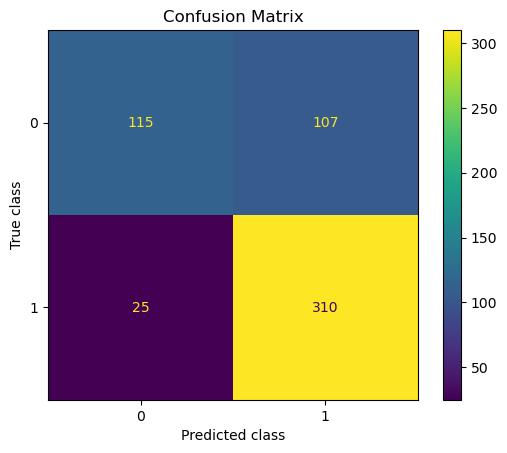

In [14]:
# Evaluate the model
y_pred = best_estimator.predict(X_val_ROS)
print("Random forest accuracy:", accuracy_score(y_val_ROS, y_pred))
print("Random forest F1 score:", f1_score(y_val_ROS, y_pred))

# Calculate the confusion matrix 
cm = confusion_matrix(y_val_ROS, y_pred)

# Show the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_).plot()

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()

The Random Forest model achieves an accuracy of 0.76, indicating that it correctly classifies 76% of the validation samples. However, the F1 score of 0.82 suggests that, despite moderate overall accuracy, the model performs particularly well in balancing precision and recall, especially for the positive class. This is supported by the confusion matrix which shows that the model correctly identifies most positive samples while only misclassifying 25 of them. The main source of error is the relatively large number of false positives, meaning the model often predicts class 1 when the true label is class 0. Overall, the model is strong at detecting positives but less reliable at rejecting negatives, which explains the higher F1 score compared to accuracy.

## With Extra Data

This subsection summarizes the performance of the model retrained using the augmented dataset that includes high-confidence predictions from X_extra

Random forest accuracy with extra data: 0.77737881508079
Random forest F1 score with extra data: 0.8364116094986808


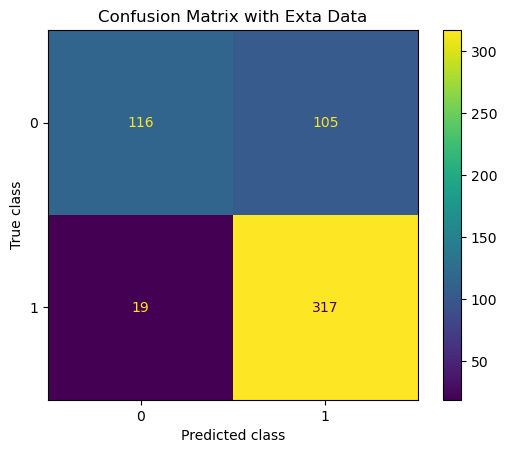

In [15]:
# Train the model for the best configuration of hyperparaeters previously found
best_estimator.fit(X_train_combined_ROS, y_train_combined_ROS)

# Evaluate the model
y_combined_pred = best_estimator.predict(X_val)
print("Random forest accuracy with extra data:", accuracy_score(y_val, y_combined_pred))
print("Random forest F1 score with extra data:", f1_score(y_val, y_combined_pred))

# Calculate the confusion matrix 
cm_2 = confusion_matrix(y_val, y_combined_pred)

# Show the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=best_estimator.classes_).plot()

plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix with Exta Data')
plt.show()

After incorporating the extra dataset, the model shows a slight improvement in performance, achieving an accuracy of 0.77 and an increased F1 score of 0.84. The updated confusion matrix indicates that the model further reduces false negatives, meaning it becomes even better at correctly identifying positive samples. False positives also decrease slightly, suggesting a modest gain in precision. The clearer separation between classes and the improved F1 score confirm that adding extra data helps the model generalize better, particularly by strengthening its ability to detect positive cases while maintaining balanced performance across both classes

At first glance, the Random Forest with extra data may appear to outperform the neural networks, especially given its high F1 score. However, this F1 score is not macro, meaning it only reflects performance for class 1, which is the easier and best-performing class. This makes the comparison unfair. When both models are compared on equal terms, the overall accuracy is higher for the CNN, showing that the neural network achieves better balanced performance across classes. Additionally, the computational cost of the Random Forest, due to the large number of trees and the random search over hyperparameters, is significantly higher, making it impractical compared with any of the neural network approaches, which train much faster and scale more efficiently.